In [1]:
# Real life data

import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, r2_score

import scipy as sp
import scipy.fftpack
import skimage as ski

from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

/home/markus/.local/lib/python3.8/site-packages/iotfunctions/bif.py:1877: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'


In [2]:
# setting to make life easier
Temperature='Temperature'
kmeans='TemperatureKmeansScore'
fft='TemperatureFFTScore'
spectral='TemperatureSpectralScore'
sal='SaliencyAnomalyScore'
gen='TemperatureGeneralizedScore'
kmeansA='kmeansAnomaly'
kmeansB='kmeansAnomalyB'
spectralA='spectralAnomaly'
fftA='fftAnomaly'
salA='salAnomaly'
genA='genAnomaly'

#kmeans_break=1.3
#spectral_break = 2.8
#fft_break = 100
#sal_break = 100
#gen_break = 30000
kmeans_break=100
spectral_break = 100
fft_break = 100
sal_break = 100
gen_break = 30000



#### What will be shown

General approach is straightforward
* read raw data in
* transform it so that it is compatible to the Monitoring pipeline
* add yet another anomaly detector based on computer vision technology. The point here is to show how to run pipeline anomaly functions 'locally', an important concept for automated testing.
* simplify the dataframe - we have only one entity, no need for an entity index
* render input data and anomaly scores properly scaled

<br>

We start with Microsoft's anomaly test data found here
https://github.com/microsoft/anomalydetector/blob/master/samples/sample.csv

and then proceed to applying anomaly detection to real life pump data


<br>


#### Current inventory of anomaly detectors by type

This is the list of functions to apply


| Detector | ML Type | Type         | How does it work |
| ------- | ------------ | ------- | ---------------- |
| KMeans | Unsupervised | Proximity | Clusters data points in centroid buckets, small buckets are outliers, score is distance to closest other bucket |
| Generalized | Unsupervised | Linear Model | Covariance matrix over data point vectors serves to measure multi-dimensional deviation |
| FFT | Unsupervised | Linear Model | Run FFT before applying Generalized |
| Spectral | Unsupervised | Linear Model | Compute signal energy to reduce dimensions |
| Saliency | Unsupervised | Linear Model | Apply saliency transform (from computer vision |
| SimpleAnomaly | **Supervised** | Ensemble | Run Gradient boosting on training data, anomaly if prediction deviates from actual data |
| --- | **Supervised** | LSTM | Train a stacked LSTM, anomaly if prediction deviates from actual data |



In [3]:
listAttr = ['timestamp','entity','vibrations','rms','accel_speed','accel_power_0','accel_power_1',
            'accel_power_2','accel_power_3','accel_power_4']

def unrollVibration(df_in):
    
    T = []
    Vx = []
    Vy = []
    Vz = []
    Ap = []
    As = []
    df_subset=df_in[['RCV_TIMESTAMP_UTC']].copy()
    
    df_subset['vibrations_xaxis'] = df_in['VIBRATIONS_XAXIS'].apply(eval)
    df_subset['vibrations_yaxis'] = df_in['VIBRATIONS_YAXIS'].apply(eval)
    df_subset['vibrations_zaxis'] = df_in['VIBRATIONS_ZAXIS'].apply(eval)
    df_subset['ap'] = df_in['ACCEL_POWER'].apply(eval)
    df_subset['as'] = df_in['ACCEL_SPEED'].apply(eval)

    np_subset = df_subset[['RCV_TIMESTAMP_UTC',
                           'vibrations_xaxis', 'vibrations_yaxis', 'vibrations_zaxis', 'ap', 'as']].values
    for row in np_subset:
        tim = np.datetime64(row[0])
        row0 = np.arange(tim, tim + np.timedelta64(15,'m'), step=np.timedelta64(1,'m'))
        #print (row0, row[1], row[2], row[3], row[4])
        for i in row[4]:
            j = eval(i)
            Ap.extend((j,j,j))
        for i in row[5]:
            j = eval(i)/1000
            As.extend((j,j,j))
        T.extend(row0.tolist())
        Vx.extend(row[1])
        Vy.extend(row[2])
        Vz.extend(row[3])
    

    #print(np.asarray(Vx))
    df_out = pd.DataFrame(data={'timestamp': np.asarray(T), 'Vx': np.asarray(Vx), 'Vy': np.asarray(Vy),
                                'Vz': np.asarray(Vz), 'Ap': np.asarray(Ap), 'As': np.asarray(As)})
    df_out['entity'] = df_in['DEVICE_ID']
    return df_out

In [4]:
df_input_raw = pd.read_csv('./Armstark04714B6046D5.csv', index_col=False, parse_dates=['RCV_TIMESTAMP_UTC'])

df_input_raw = unrollVibration(df_input_raw)

#df_input_raw.head(2)
df_input_raw.shape

(129300, 7)

In [5]:
# Now we proceed to customer data - BAD CASE

# Get stuff in
df_inputb_raw = pd.read_csv('./Armstark04714B604101.csv', index_col=False, parse_dates=['RCV_TIMESTAMP_UTC'])

df_inputb_raw = unrollVibration(df_inputb_raw)
df_inputb_raw.head(2)

,timestamp,Vx,Vy,Vz,Ap,As,entity
0,2020-01-01 00:02:12.713,-0.0625,-0.0908,-1.0332,2.365,1.036,04714B604101
1,2020-01-01 00:03:12.713,0.0361,0.0078,-0.9141,2.365,1.036,04714B604101


In [9]:
df_moreinput_raw = pd.read_csv('./ArmstarkMoreData.csv', index_col=False, parse_dates=['RCV_TIMESTAMP_UTC'])
df_moreinput_raw['entity'] = df_moreinput_raw['DEVICE_ID']
df_moreinput_raw['timestamp'] = df_moreinput_raw['RCV_TIMESTAMP_UTC']
df_moreinput_raw = df_moreinput_raw.drop(columns=['DEVICE_ID','RCV_TIMESTAMP_UTC','TIMESTAMP', 'UPDATED_UTC'])

df_moreinput_ra2 = df_moreinput_raw.set_index(['entity','timestamp']).dropna()
df_more = df_moreinput_ra2.loc['04714B6046D5'].copy()
df_moreb = df_moreinput_ra2.loc['04714B604101'].copy()


In [10]:
scal = np.arange(0, df_more['SPEED'].size, 1)
linear_interpolspeed = sp.interpolate.interp1d(
    scal, df_more['SPEED'].values, kind="linear", fill_value="extrapolate")
scal2 = np.linspace(0, df_more['SPEED'].size, df_moreinput_ra2.shape[0])
df_input_raw['speed'] = linear_interpolspeed(scal2) / 1000


scalb = np.arange(0, df_moreb['SPEED'].size, 1)
linear_interpolspeed = sp.interpolate.interp1d(
    scalb, df_moreb['SPEED'].values, kind="linear", fill_value="extrapolate")
scalb2 = np.linspace(0, df_moreb['SPEED'].size, df_moreinputb_ra2.shape[0])
df_inputb_raw['speed'] = linear_interpolspeed(scalb2) / 1000

ValueError: Length of values does not match length of index

In [8]:
df_input = df_input_raw.set_index(['entity', 'timestamp'])
df_inputb = df_inputb_raw.set_index(['entity', 'timestamp'])

#### Try out supervised methods

* Train a stacked LSTM
* Run gradient boosting


In [3]:
# part of mmfunctions
import telemanom
from telemanom.helpers import Config
from telemanom.errors import Errors
import telemanom.helpers as helpers
from telemanom.channel import Channel
from telemanom.modeling import Model

conf = Config("./telemanom/config.yaml")

#list_attr=['Vx','Vy','Vz']
list_attr=['Vx','speed'] # minimal

#list_attr=['vibrations','accel_power_0']
conf.dictionary['l_s'] = 250
conf.dictionary['epochs'] = 80
conf.dictionary['dropout'] = 0.2
conf.l_s = 250
# conf.epochs = 80
conf.dropout = 0.2
conf.lstm_batch_size=80

Using TensorFlow backend.


In [4]:

tel_input = df_input[list_attr].values   # n-dim numpy array - predict first value
tel_input = abs(tel_input - tel_input.mean())
tel_inputb = df_inputb[list_attr].values
tel_inputb = abs(tel_inputb - tel_inputb.mean())
#np.save("telemanom/data/train/Armstarknew.npy", tel_input)
#np.save("telemanom/data/test/Armstarknew.npy", tel_inputb)
tel_input.shape

NameError: name 'df_input' is not defined

In [11]:
# Load data from 
device="Armstarknew"
chan = Channel(conf, device)
helpers.make_dirs(conf.use_id, conf, "./telemanom")
print(chan)
conf


Channel:Channel


In [12]:
print(chan.ffttrain)

None


In [13]:
#chan.delete_data("./telemanom")
chan.config.FFT = False
chan.load_data("./telemanom")
# chan.train
#dfA = pd.DataFrame(chan.ffttrain)
dfA = pd.DataFrame(chan.train)
dfA.head(2)

2020-07-23T18:45:41.566 INFO telemanom.shape_data FFT channel: False
(129300, 2)
2020-07-23T18:45:42.105 INFO telemanom.shape_data FFT channel: False
(129195, 2)


,0,1
0,0.541443,0.538457
1,0.540543,0.538457


In [7]:
# chan.train

vibxg = df_input['Vx'].values
vibxb = df_inputb['Vx'].values
accpg = df_input['Ap'].values
accpb = df_inputb['Ap'].values
accsg = df_input['speed'].values
accsb = df_inputb['speed'].values

fig, ax = plt.subplots(4, 1, figsize=(20, 18))
cnt = 0 
ax[cnt].plot(vibxg, color='blue', label='vibration x')
#ax[cnt].plot(accpg/4-0.5, color='green', label='acc power')
ax[cnt].plot(accsg, color='red', label='pump speed')
ax[cnt].legend()
ax[cnt].set_title('Train (good) data')

cnt += 1
ax[cnt].plot(vibxb, color='blue', label='vibration x')
ax[cnt].plot(accpb/4-0.5, color='green', label='acc power')
ax[cnt].plot(accsb, color='red', label='pump speed')
ax[cnt].set_title('Test (bad) data')
ax[cnt].legend()

#cnt += 1
#ax[cnt].plot((tr[:]-0), color='blue')
#ax[cnt].set_title('Spectrum: Train (good) data')
#cnt += 1
#ax[cnt].plot((te[:]-0), color='blue')
#ax[cnt].set_title('Spectrum: Test (bad) data')

noverlap = 8
NFFT = 512
cnt += 1
PxxG, freqsG, binsG, imG = ax[cnt].specgram(chan.train[:,0],
                                          Fs=2, NFFT=NFFT, 
                                          detrend='mean', noverlap=NFFT-noverlap, mode='psd')
cnt += 1
PxxB, freqsB, binsB, imB = ax[cnt].specgram(chan.test[:,0],
                                          Fs=2, NFFT=NFFT, 
                                          detrend='mean', noverlap=NFFT-noverlap, mode='psd')

plt.show()

NameError: name 'df_input' is not defined

In [8]:
# make sure to downgrade to sklearn 0.22.2 (no >= 0.23)
from watson_machine_learning_client import WatsonMachineLearningAPIClient

wml_credentials = {
  "apikey": "B9UrvzboYPrHpIV_yDXTh4D3bMbE7NYuFlS46bmJalX_",
  "iam_apikey_description": "Auto-generated for key a9569793-f9e6-49c8-ace2-c3d210c4e2ce",
  "iam_apikey_name": "LocalTests",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Manager",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/f8971897be4e1464541021c645cd53fd::serviceid:ServiceId-a868a68f-79f6-4255-9945-379356c7249a",
  "instance_id": "8bd30bb4-2c05-440c-8e1e-6cefab74e2ee",
  "url": "https://eu-de.ml.cloud.ibm.com"
}

client = WatsonMachineLearningAPIClient(wml_credentials)


In [9]:
rep_list = client.runtimes.list(limit=4000)

--------------------------  --------------------------  ------------------------  --------
GUID                        NAME                        CREATED                   PLATFORM
do_12.10                    do_12.10                    2020-03-20T04:19:17.471Z  do
xgboost_0.90-py3.6          xgboost_0.90-py3.6          2020-03-20T04:19:03.205Z  python
scikit-learn_0.22-py3.6     scikit-learn_0.22-py3.6     2020-03-20T04:18:53.589Z  python
spark-mllib_2.4             spark-mllib_2.4             2020-02-06T09:30:35.538Z  spark
tensorflow_1.15-py3.6       tensorflow_1.15-py3.6       2020-02-06T09:30:30.574Z  python
pytorch-onnx_1.2-py3.6      pytorch-onnx_1.2-py3.6      2020-02-06T09:29:58.456Z  python
pytorch-onnx_1.2-py3.6-edt  pytorch-onnx_1.2-py3.6-edt  2020-02-06T09:29:54.031Z  python
tensorflow_1.14-py3.6       tensorflow_1.14-py3.6       2019-10-23T09:54:32.847Z  python
pytorch-onnx_1.1-py3.6      pytorch-onnx_1.1-py3.6      2019-10-23T09:54:02.251Z  python
pytorch-onnx_1.1-py3.6

In [19]:

def kfp_wml_pipeline():
    GITHUB_TOKEN='ad7e5d3d34e79ac5d06210e74546c36b4bbc86ab',
    CONFIG_FILE_URL='https://raw.github.ibm.com/markus-mueller/Armstrong/master/creds.ini',
    train_code='tf-model.zip',
    execution_command='\'python3 convolutional_network.py --trainImagesFile ${DATA_DIR}/train-images-idx3-ubyte.gz --trainLabelsFile ${DATA_DIR}/train-labels-idx1-ubyte.gz --testImagesFile ${DATA_DIR}/t10k-images-idx3-ubyte.gz --testLabelsFile ${DATA_DIR}/t10k-labels-idx1-ubyte.gz --learningRate 0.001 --trainingIters 20000\'',
    framework='tensorflow',
    framework_version='1.15',
    runtime = 'python',
    runtime_version='3.6',
    run_definition = 'wml-tensorflow-definition',
    run_name = 'wml-tensorflow-run',
    model_name='wml-tensorflow-mnist',
    scoring_payload='tf-mnist-test-payload.json',
    compute_name='k80',
    compute_nodes='1'


lib_meta = {
    client.runtimes.LibraryMetaNames.NAME: 'wml-keras-lstm',
    client.runtimes.LibraryMetaNames.VERSION: '1.15-py3.6',
    client.runtimes.LibraryMetaNames.FILEPATH: '/app/my-model.zip',
    client.runtimes.LibraryMetaNames.PLATFORM: {"name": 'wml-keras-lstm', "versions": ['1.15-py3.6']}
}
lib_details = client.runtimes.store_library(lib_meta)


2020-07-23T15:57:11.609 WARNING watson_machine_learning_client.wml_client_error.__init__ Failure during creation of libraries.
Reason: [Errno 2] No such file or directory: '/app/my-model.zip'


WMLClientError: Failure during creation of libraries.
Reason: [Errno 2] No such file or directory: '/app/my-model.zip'

In [ ]:
print lib_details

In [14]:
# producing overlapping windows of length 260 for lookback (250) and prediction (10)
chan.shape_data(chan.train, train=True)
chan.shape_data(chan.test, train=False)

2020-07-23T18:46:01.826 INFO telemanom.shape_data FFT channel: False
(129300, 2)
2020-07-23T18:46:02.367 INFO telemanom.shape_data FFT channel: False
(129195, 2)


In [17]:
# init the Keras double stacked LSTM model
model = Model(conf, conf.use_id, chan, "./telemanom", False)

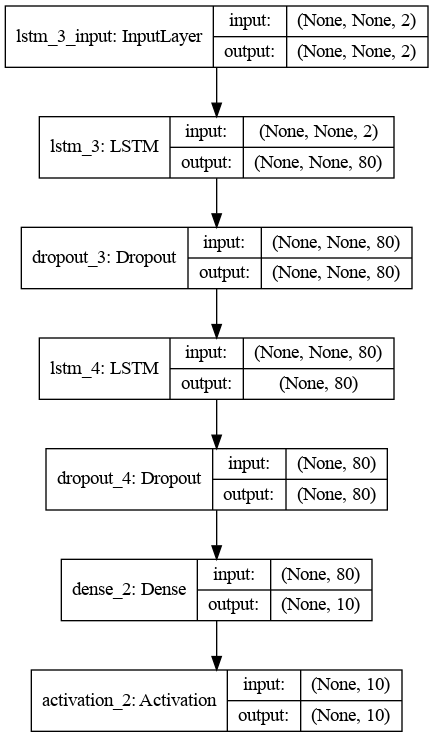

In [19]:
from keras.utils.vis_utils import plot_model
plot_model(model.model, show_shapes=True, show_layer_names=True)

In [9]:
# drink a coffee - training takes roughly 30 minutes
model.train_new(chan)

Train on 103232 samples, validate on 25808 samples
Epoch 1/35
103232/103232 [==============================] - 425s 4ms/step - loss: 0.0041 - val_loss: 0.0014
Epoch 2/35
103232/103232 [==============================] - 400s 4ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 3/35
103232/103232 [==============================] - 402s 4ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 4/35
103232/103232 [==============================] - 391s 4ms/step - loss: 0.0015 - val_loss: 0.0014


#### Training parameters

```
loss_metric: 'mse'    # minimize mean square error
optimizer: 'adam'     # sort of adaptive stochastic gradient descent
validation_split: 0.2 # 20% of the data is used for validating (val_loss)
dropout: 0.3          # ditch 30% of the LSTMs results when minimizing the loss function to avoid overfitting
lstm_batch_size: 64   # number of training data batches to evaluate per optimizer run to update the model’s parameters

patience: 10          # try at least 10 times to decrease val_loss smaller by ...
min_delta: 0.0003     # ... at least min_delta, else stop, so we get at least 'patience' epochs
epochs: 35            # no more than 35 passes through the entier training dataset.

l_s: 250              # lookback: num previous timesteps provided to model to predict future values
n_predictions: 10     # number of steps ahead to predict
```

This is defined in `telemanom/config.yaml`
<br>

In [28]:
print (model.model)

NameError: name 'model' is not defined

In [128]:
# predicting takes roughly 12 secs
model.batch_predict(chan, Path="./telemanom")

In [129]:
# smooth the prediction error and apply exponential weights to it
errors = Errors(chan, conf, conf.use_id, "./telemanom")

#  for each overlapping window establish a threshold so that removing error points above it 
# maximizes the reduction of mean and standard deviation. Sort of an adaptive z-score 
errors.process_batches(chan)

2020-03-16T21:15:19.953 INFO telemanom.__init__ normalized prediction error: 0.06


In [130]:
print (errors.E_seq, " \n ", errors.anom_scores)

[(8650, 9049), (19850, 20249), (41150, 41649), (95450, 95849), (99650, 99749), (101750, 101849)]  
  [{'start_idx': 8400, 'end_idx': 8499, 'score': 1.8819864334481131}, {'start_idx': 8500, 'end_idx': 8599, 'score': 2.4118219828938288}, {'start_idx': 8600, 'end_idx': 8699, 'score': 2.8350391123177623}, {'start_idx': 8700, 'end_idx': 8799, 'score': 3.129021297489508}, {'start_idx': 19600, 'end_idx': 19699, 'score': 6.1292143015223886}, {'start_idx': 19700, 'end_idx': 19799, 'score': 6.164415706483887}, {'start_idx': 19800, 'end_idx': 19899, 'score': 6.160624087183549}, {'start_idx': 19900, 'end_idx': 19999, 'score': 6.180099691069643}, {'start_idx': 40900, 'end_idx': 40999, 'score': 1.549790375651836}, {'start_idx': 41000, 'end_idx': 41099, 'score': 1.9420454097273365}, {'start_idx': 41100, 'end_idx': 41199, 'score': 2.3567182735433736}, {'start_idx': 41200, 'end_idx': 41299, 'score': 2.2956307295217417}, {'start_idx': 41300, 'end_idx': 41399, 'score': 2.3550736364688305}, {'start_idx': 

In [131]:
model.save("./telemanom")

In [132]:
# How good are we doing ?

model.model.evaluate(chan.X_test, chan.y_test)

128935/128935 [==============================] - 163s 1ms/step


0.00590012299512361

In [133]:
model.model.metrics_names

['loss']

In [134]:
model.batch_predict(chan, Path="./telemanom", Train=False)


We're seeing a prediction lag, maybe due to the nature of the timeseries data- see also this [article](https://stats.stackexchange.com/questions/280939/lag-between-predicted-output-and-real-output-in-time-series-prediction-directio).

From this article:

If the data generating process is a random walk, 

$x_t = x_{t-1} + \varepsilon_t$

with $\varepsilon_t \sim i.i.d.(0,\sigma^2)$ the optimal* one-step-ahead prediction is 

\begin{equation}
\hat x_{t+1|t}:=\mathbb{E}(x_{t+1}|x_{t},x_{t-1},\dots)=x_{t}
\end{equation}

which happens to be the realization $x_{t+1}$ lagged by one ($x_{t}$ is $x_{t+1}$ lagged by 1). Given the data generating process, this apparently lagging prediction is the best we can get*. Then there is no way we can "fix" the "problem of lagging predictions; the problem is built-in due to the nature of the data generating process.


Text(0.5, 1.0, 'Vibration Forecast x-axis - predicted')

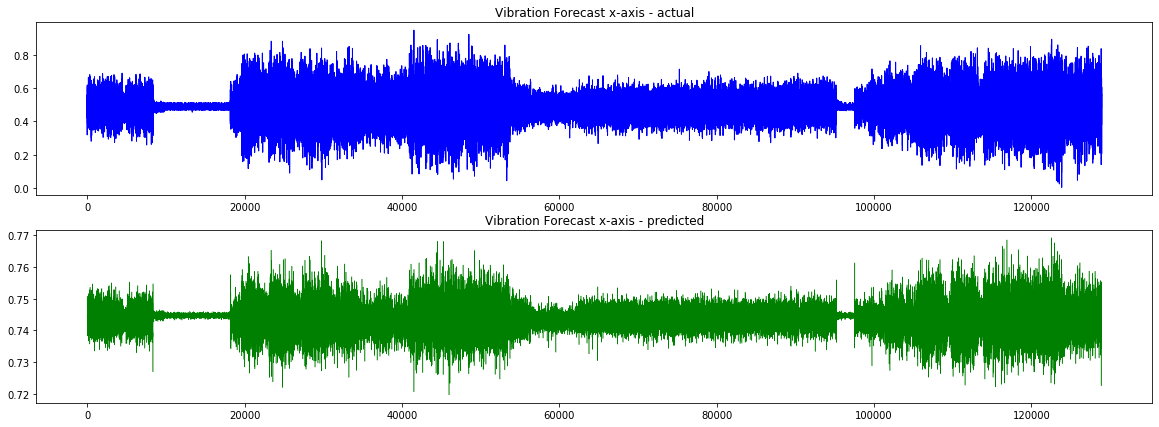

In [145]:
arr = np.ones(chan.y_test.size)
fig, ax = plt.subplots(2, 1, figsize=(20, 7))
#ax[0].plot(chan.y_train_hat[:8200] * 10, lw=0.2, color='green')  # to be done
ax[0].plot(chan.y_test[:,0], lw=1, color='blue', label='vibration')
ax[0].set_title('Vibration Forecast x-axis - actual')
#ax[1].plot(chan.y_hat[:chan.y_hat.shape[0] // 2] * 100 - 113.4, lw=0.5, color='green')
ax[1].plot(chan.y_hat[:chan.y_hat.shape[0] // 2] * 1.5 - 0, lw=0.5, color='green')
ax[1].set_title('Vibration Forecast x-axis - predicted')

[0.1774626  0.09110776 0.10607143 ... 0.10401793 0.05571466 0.07051344]


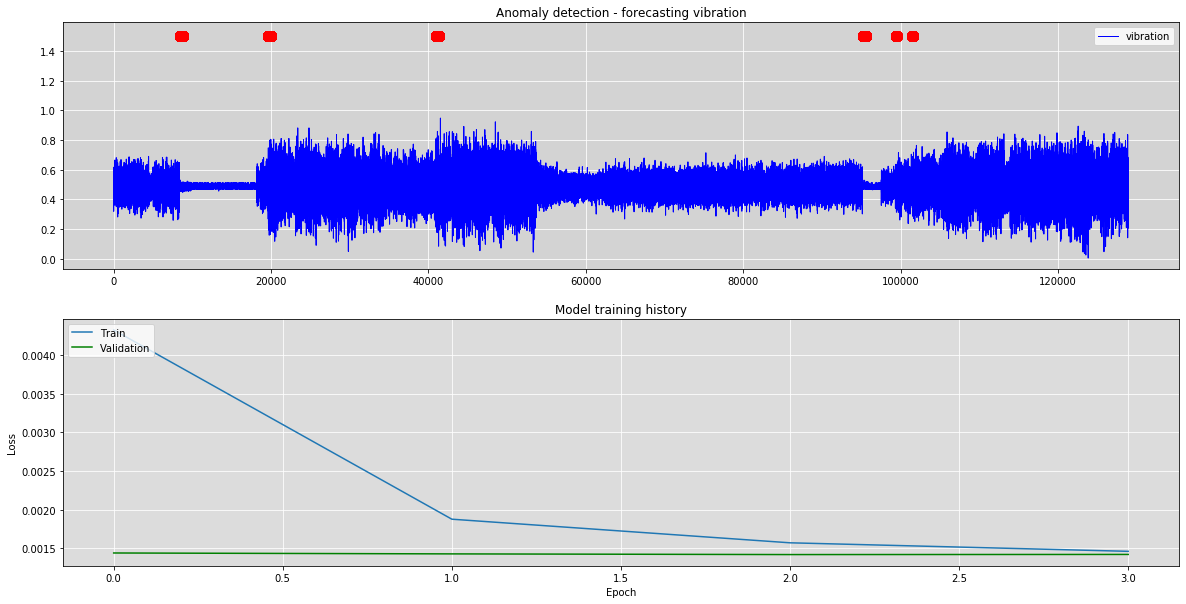

In [136]:
short = chan.y_hat.shape[0] // 2

npic = 1
fig, ax = plt.subplots(npic+1, 1, figsize=(20, (npic+1) * 5))
ax[npic-1].set_title('Anomaly detection - forecasting vibration')
ax[npic-1].plot(chan.y_test[:,0], lw=1, color='blue', label='vibration')

#ax.scatter(x_axis, temp_sal_high, lw=8, color='red')
for asc in errors.anom_scores:
    x_axis = np.arange(asc['start_idx'],asc['end_idx'],1)
    y_axis = np.zeros(asc['end_idx'] - asc['start_idx'])
    ax[npic-1].grid(True, color='white')
    ax[npic-1].set_facecolor('lightgrey')
    ax[npic-1].scatter(x_axis,y_axis+1.5, lw=5, color='red', zorder=10)
ax[npic-1].grid(True, color='white')
ax[npic-1].set_facecolor('lightgrey')
#ax[npic-1].plot(abs(chan.y_hat - chan.y_test[:,0]) + 3, lw=3, color='green', label='deviation')
#ax[npic-1].plot((chan.y_hat[:short] - 0.4)*6, lw=2, color='darkgreen',label='prediction',zorder=5)
ax[npic-1].legend()
    
ax[npic].set_xlabel('Epoch')
ax[npic].set_ylabel('Loss')
ax[npic].set_title('Model training history')
ax[npic].plot(model.history.history['loss'])
ax[npic].plot(model.history.history['val_loss'],color='green')
ax[npic].grid(True, color='white')
ax[npic].set_facecolor('gainsboro')
ax[npic].legend(['Train', 'Validation'], loc='upper left')


lstmscore = np.abs(abs(chan.y_hat[:short] - chan.y_test[:,1]))
print (lstmscore)
#ax[1].plot(chan.test[:,0], lw=1, color='blue')
#ax[1].set_xlabel('Date')
#ax[1].set_ylabel('Compare with raw training data')


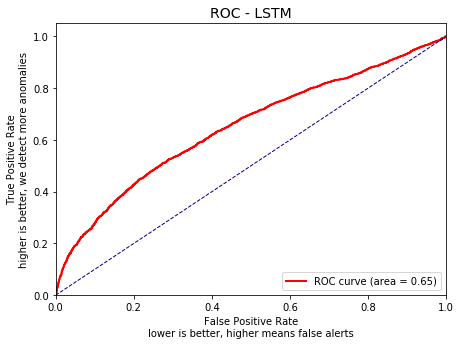

In [37]:
# ROC curve LSTM

fprFg, tprFg, _ = roc_curve(yyy_test[0:yyy_test.size - conf.l_s - conf.n_predictions], lstmscore)
roc_aucFg = auc(fprFg, tprFg)

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.plot(fprFg, tprFg, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_aucFg)
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate\nlower is better, higher means false alerts')
plt.ylabel('True Positive Rate\nhigher is better, we detect more anomalies')
plt.title('ROC - LSTM', fontsize=14)
plt.legend(loc="lower right")
plt.show()


In [47]:
# Now run gradient boosting - using lightGBM

X_train = df_input[['accel_power_0','accel_power_1','accel_power_2',
                    'accel_power_3','accel_power_4']].to_numpy()
y_train = df_input['vibrations'].to_numpy()

In [48]:
import lightgbm
gbr = lightgbm.LGBMRegressor(n_estimators=4000, learning_rate=0.000001, num_leaves=40,
                           max_depth=20, random_state=42, loss='huber').fit(X_train, y_train)


In [49]:

pred_good = gbr.predict(X_train)
rmse = metrics.mean_squared_error(y_train, pred_good)
gbscoreg = np.abs(pred_good - y_train)
print (rmse)

0.001106535670881264


In [50]:
X_bad = df_inputb[['accel_power_0','accel_power_1','accel_power_2',
                   'accel_power_3','accel_power_4']].to_numpy()
y_bad = df_inputb['vibrations'].to_numpy()
pred_bad = gbr.predict(X_bad) 
rmseb = metrics.mean_squared_error(y_bad, pred_bad)
gbscore = np.abs(pred_bad - y_bad)
print (rmseb)

0.009797515412096496


Text(0.5, 1.0, 'Good Case - no anomalous deviation from prediction')

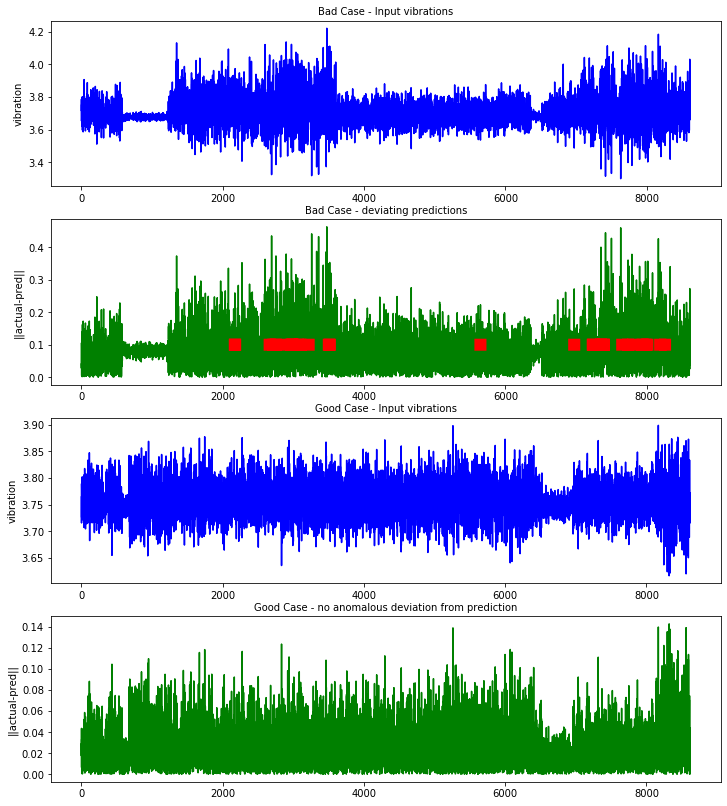

In [51]:
separator = 0.2
anomalygb = gbscore.copy() #(gbscore > separator) # * (separator + 0.1)
anomalygb[anomalygb <= separator] = 0
anomalygb[anomalygb > separator] = separator/2
anomalygb[anomalygb == 0] = np.nan
anomalygg = gbscoreg.copy()
anomalygg[anomalygg <= separator] = 0
anomalygg[anomalygg > separator] = separator/2
anomalygg[anomalygg == 0] = np.nan

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12,14)) 
ax1.plot(y_bad, color='blue')
ax1.set_title('Bad Case - Input vibrations', fontsize=10)
ax1.set_ylabel('vibration')
ax2.plot(gbscore, color='green')
ax2.plot(anomalygb, color='red', lw=12, zorder=10)
ax2.set_ylabel('||actual-pred||')
ax2.set_title('Bad Case - deviating predictions', fontsize=10)
ax3.plot(y_train, color='blue')
ax3.set_ylabel('vibration')
ax3.set_title('Good Case - Input vibrations', fontsize=10)
ax4.plot(gbscoreg, color='green')
ax4.plot(anomalygg, color='red', lw=12, zorder=10)
ax4.set_ylabel('||actual-pred||')
ax4.set_title('Good Case - no anomalous deviation from prediction', fontsize=10)



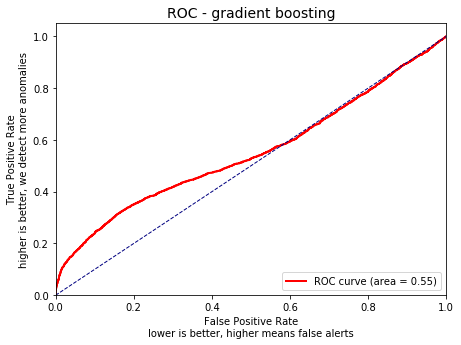

In [52]:
# ROC curve Gradient Boosting

fprFg, tprFg, _ = roc_curve(yyy_test, gbscore)
roc_aucFg = auc(fprFg, tprFg)

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.plot(fprFg, tprFg, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_aucFg)
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate\nlower is better, higher means false alerts')
plt.ylabel('True Positive Rate\nhigher is better, we detect more anomalies')
plt.title('ROC - gradient boosting', fontsize=14)
plt.legend(loc="lower right")
plt.show()


#### Results

Gradient boosting appeared to do much better until Shradda fixed the ROC curve plot.

Now I understand (and accept) why I had to explicitly disable the r2_score check in the pipeline's GBMRegressor to enforce saving the model to Cloud Object Store.

Training time is much shorter compared to the NASA model, but there is a price


In [53]:
from sklearn.metrics import r2_score

'''
Coefficent of determinatoin: the proportion of the variance in the dependent variable 
that is predictable from the independent variable(s). It provides a measure of how well 
observed outcomes are replicated by the model, based on the proportion of total variation 
of outcomes explained by the model
Best posible score = 1.0
Values of r2 outside 0-1: model fits data worse than a horizontal hyperplane
'''

print('R_sq/Test Variance score:' + str(r2_score(y_bad, pred_bad)))

R_sq/Test Variance score:-0.25058676111247435


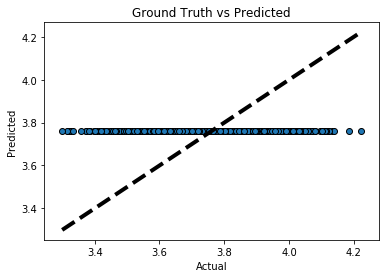

In [54]:
from sklearn.model_selection import cross_val_predict

fig, ax = plt.subplots()
ax.scatter(y_bad, pred_bad, edgecolors=(0, 0, 0))
ax.plot([y_bad.min(), y_bad.max()], [y_bad.min(), y_bad.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()